# **Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
import time
import warnings
warnings.filterwarnings('ignore')

# **Load the dataset**

In [ ]:
df = pd.read_csv("Mall_Customers.csv")
print("Initial dataset shape:", df.shape)
df.head()

Initial dataset shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# **Check for missing values**

In [ ]:
print("Missing values in each column:")
print(df.isnull().sum())
#no messing values

Missing values in each column:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


# **Preprocessing**

In [ ]:
df.rename(columns={'Annual Income (k$)': 'Income', 'Spending Score (1-100)': 'SpendingScore'}, inplace=True)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
features = ['Gender', 'Age', 'Income', 'SpendingScore']
X = df[features]
#just name replacment

## **Scaling**

In [ ]:
#we should use StandardScaler to data beacause the pCA is sensitive to scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **PCA**

explained variance ratios: [0.33690046 0.26230645 0.23260639 0.16818671]
cumulative explained variance: [0.33690046 0.5992069  0.83181329 1.        ]


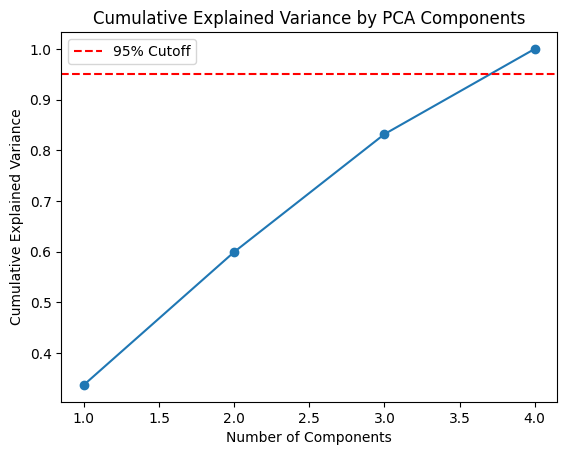

In [ ]:
#we apply the pca on the scaled data and Visualize it to see what n_components we should use
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


explained_variance_mall = np.cumsum(pca.explained_variance_ratio_)

print('explained variance ratios:', pca.explained_variance_ratio_)

print('cumulative explained variance:', explained_variance_mall)



plt.plot(range(1, len(explained_variance_mall)+1), explained_variance_mall, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Cutoff')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.show()


In [ ]:
pca = PCA()

pca.fit(X_scaled)

explained_ratios = pca.explained_variance_ratio_



total_variances = 0

n_components_mall = 0

for ratio in explained_ratios:

    total_variances += ratio

    n_components_mall += 1

    if total_variances >= 0.95:

        break

print("number of components :", n_components_mall)


number of components : 4


# **applies PCA with selected components and visualizes the data using the first two principal components**

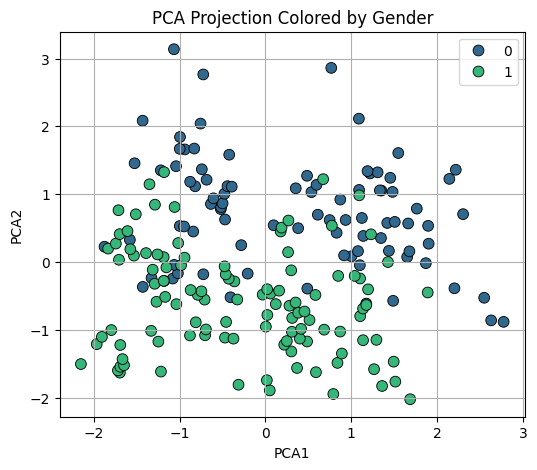

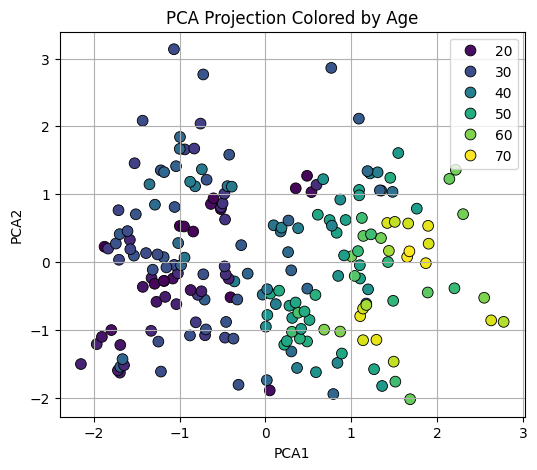

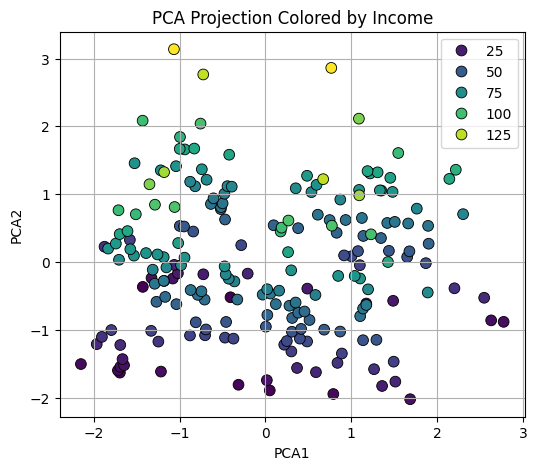

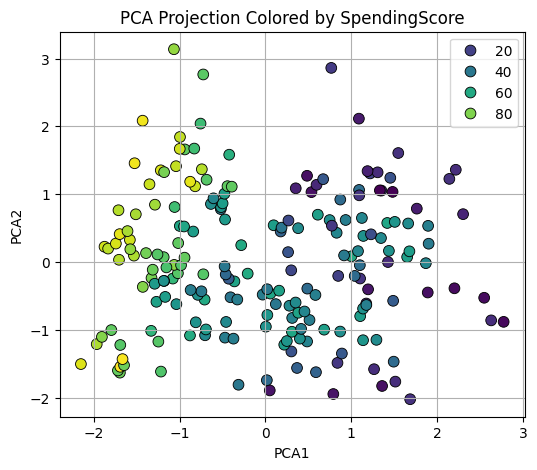

In [ ]:
pca_mall_final = PCA(n_components=n_components_mall)

X_mall_pca = pca_mall_final.fit_transform(X_scaled)


pca_df = pd.DataFrame(X_pca[:, :2], columns=["PCA1", "PCA2"])
pca_df = pd.concat([pca_df, df[features].reset_index(drop=True)], axis=1)


for col in features:
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=pca_df,
        x="PCA1", y="PCA2",
        hue=col,
        palette="viridis",
        s=60,
        edgecolor='black'
    )
    plt.title(f"PCA Projection Colored by {col}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


# **t-SNE**

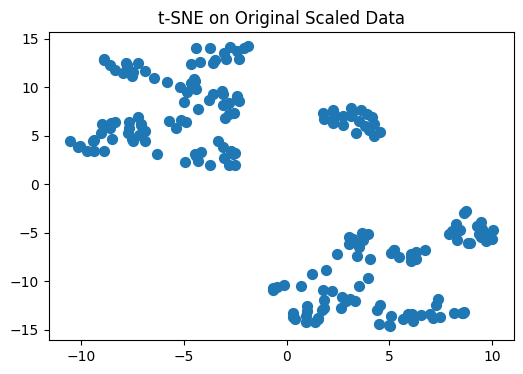

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_mall_pca)

#t-SNE visualization

plt.figure(figsize=(6,4))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=50)
plt.title("t-SNE on Original Scaled Data")
plt.show()

# **KMeans clustering**

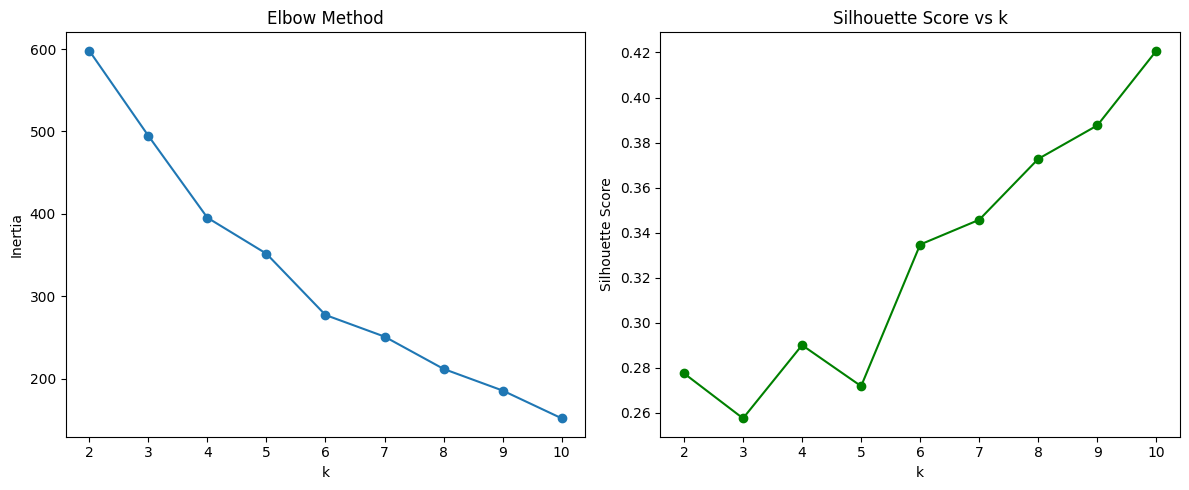

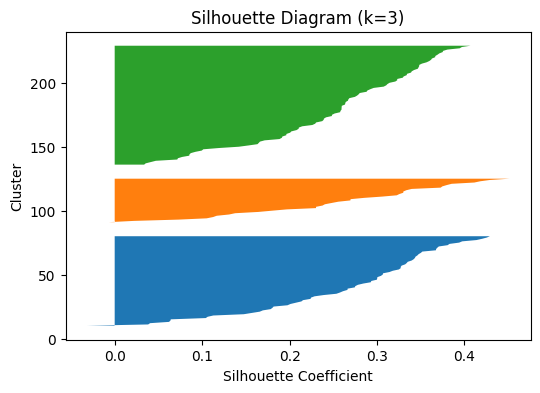

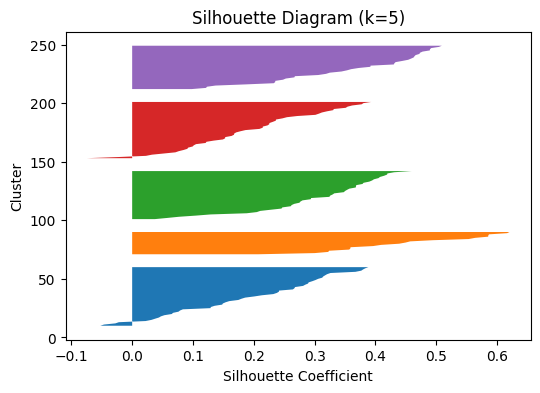

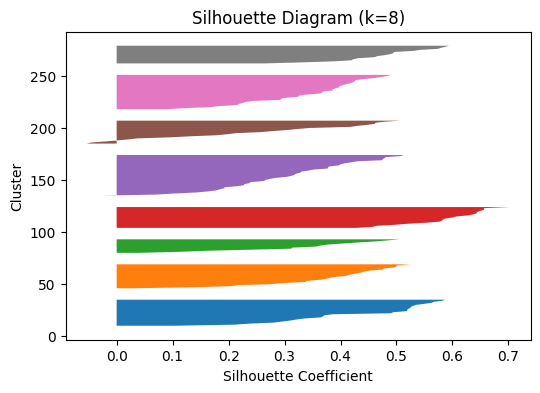

In [ ]:
inertia = []
sil_scores = []
K = range(2, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_mall_pca)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_mall_pca, km.labels_))

# Plot Elbow and Silhouette Score
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='green')
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

# Silhouette diagram for k = 3, 5, 8
for k_val in [3, 5, 8]:
    km = KMeans(n_clusters=k_val, random_state=42)
    labels = km.fit_predict(X_mall_pca)
    sil_samples = silhouette_samples(X_mall_pca, labels)

    plt.figure(figsize=(6,4))
    y_lower = 10
    for i in range(k_val):
        ith_cluster_sil_values = sil_samples[labels == i]
        ith_cluster_sil_values.sort()
        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values)
        y_lower = y_upper + 10
    plt.title(f"Silhouette Diagram (k={k_val})")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.show()

# **MiniBatch KMeans**

In [ ]:
start = time.time()
mbkm = MiniBatchKMeans(n_clusters=5, random_state=42)
mbkm.fit(X_mall_pca)
end = time.time()
print("MiniBatchKMeans time:", round(end - start, 4), "seconds")
print("Inertia:", mbkm.inertia_)
print("Silhouette Score:", silhouette_score(X_mall_pca, mbkm.labels_))

MiniBatchKMeans time: 0.016 seconds
Inertia: 326.8873544598852
Silhouette Score: 0.3168476768813833


# **DBSCAN**

In [ ]:
eps_values = np.arange(0.3, 1.1, 0.1)
min_samples_values = range(3, 11)

print("DBSCAN Grid Search Results:")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_mall_pca)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Skip if no clusters found
        if n_clusters <= 1:
            continue

        # Silhouette score requires > 1 cluster
        sil = silhouette_score(X_mall_pca, labels)
        print(f"eps={eps:.1f}, min_samples={min_samples} → clusters={n_clusters}, noise={n_noise}, silhouette={sil:.3f}")


DBSCAN Grid Search Results:
eps=0.3, min_samples=3 → clusters=14, noise=144, silhouette=-0.226
eps=0.3, min_samples=4 → clusters=4, noise=177, silhouette=-0.289
eps=0.4, min_samples=3 → clusters=18, noise=97, silhouette=-0.005
eps=0.4, min_samples=4 → clusters=8, noise=133, silhouette=-0.122
eps=0.4, min_samples=5 → clusters=4, noise=165, silhouette=-0.205
eps=0.4, min_samples=6 → clusters=2, noise=177, silhouette=-0.141
eps=0.4, min_samples=7 → clusters=2, noise=182, silhouette=-0.182
eps=0.5, min_samples=3 → clusters=18, noise=49, silhouette=0.215
eps=0.5, min_samples=4 → clusters=12, noise=76, silhouette=0.121
eps=0.5, min_samples=5 → clusters=9, noise=105, silhouette=0.012
eps=0.5, min_samples=6 → clusters=5, noise=135, silhouette=-0.095
eps=0.5, min_samples=7 → clusters=4, noise=152, silhouette=-0.070
eps=0.5, min_samples=8 → clusters=2, noise=169, silhouette=-0.075
eps=0.5, min_samples=9 → clusters=3, noise=169, silhouette=-0.123
eps=0.5, min_samples=10 → clusters=2, noise=178, s

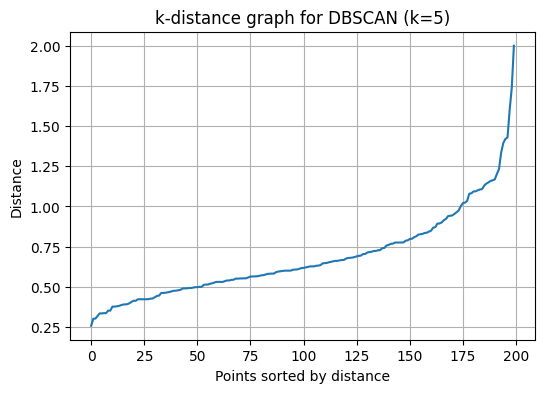

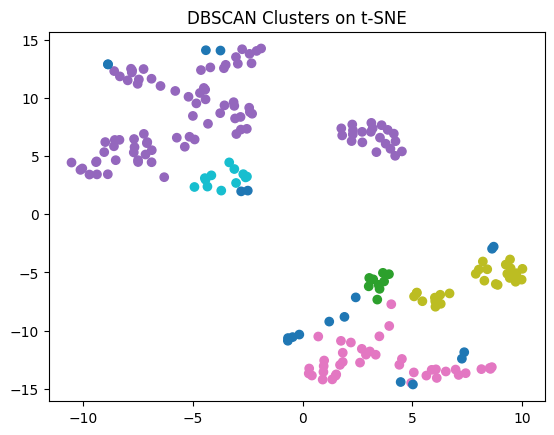

DBSCAN Clusters: 5


In [ ]:
# Helper to choose eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_mall_pca)
distances, indices = neighbors_fit.kneighbors(X_mall_pca)
distances = np.sort(distances[:,4])
plt.figure(figsize=(6,4))
plt.plot(distances)
plt.title("k-distance graph for DBSCAN (k=5)")
plt.ylabel("Distance")
plt.xlabel("Points sorted by distance")
plt.grid(True)
plt.show()

# Try DBSCAN with chosen eps
dbscan = DBSCAN(eps=0.8, min_samples=5)
db_labels = dbscan.fit_predict(X_mall_pca)
n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=db_labels, cmap='tab10')
plt.title("DBSCAN Clusters on t-SNE")
plt.show()

print("DBSCAN Clusters:", n_clusters_db)

# **Compare Table**

In [ ]:
comparison = pd.DataFrame({
    'Algorithm': ['KMeans', 'MiniBatchKMeans', 'DBSCAN'],
    'Inertia': [KMeans(n_clusters=5).fit(X_scaled).inertia_, mbkm.inertia_, 'N/A'],
    'Silhouette Score': [silhouette_score(X_scaled, KMeans(n_clusters=5).fit_predict(X_scaled)),
                         silhouette_score(X_scaled, mbkm.labels_),
                         'N/A'],
    'Execution Time (s)': ['~0.1', round(end - start, 4), '~0.1'],
    'Number of Clusters': [5, 5, n_clusters_db]
})
print("\nClustering Comparison Table:")
print(comparison)


Clustering Comparison Table:
         Algorithm     Inertia Silhouette Score Execution Time (s)  \
0           KMeans  331.442083         0.269543               ~0.1   
1  MiniBatchKMeans  326.887354         0.316848              0.016   
2           DBSCAN         N/A              N/A               ~0.1   

   Number of Clusters  
0                   5  
1                   5  
2                   5  


# **Feature Engineering**

In [ ]:
df['Income_per_Age'] = df['Income'] / df['Age']
df['Score_to_Income'] = df['SpendingScore'] / df['Income']
print(df[['Income_per_Age', 'Score_to_Income']].describe())

       Income_per_Age  Score_to_Income
count      200.000000       200.000000
mean         1.751656         1.068544
std          0.954720         0.973406
min          0.283582         0.012821
25%          0.913443         0.632803
50%          1.579802         0.887993
75%          2.486111         1.130245
max          4.566667         5.400000
